In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/kernel7769dea63e/__output__.json
/kaggle/input/kernel7769dea63e/mergeBTC2018-19.pkl
/kaggle/input/kernel7769dea63e/Bitcoin2017-18.pkl
/kaggle/input/kernel7769dea63e/__notebook__.ipynb
/kaggle/input/kernel7769dea63e/__results__.html
/kaggle/input/kernel7769dea63e/custom.css
/kaggle/input/kernel7769dea63e/pricesBTC2018-19.pkl
/kaggle/input/all-crypto-currencies/crypto-markets.csv
/kaggle/input/crypto-predict/data_1.json


Reading Reddit Dataset

In [ ]:
ddf = pd.read_json('/kaggle/input/crypto-predict/data_1.json', lines=True)

In [ ]:
ddf.head(1)

In [ ]:
#Filtering Columns
def filter_col(df, cols):
    return df.drop(df.columns[[cols]], axis=1)

ddf= filter_col(ddf,[0,1,2,3,4,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41])

In [ ]:
ddf.head(1)

In [ ]:
#Changing to human readable datetime


def to_datetime(df):
    return pd.to_datetime(df['created_utc'],unit='s')

ddf['datetime']=to_datetime(ddf)

In [ ]:
#Delete removed and deleted comments

ddf=ddf[ddf.body!='[removed]']
ddf=ddf[ddf.body!='[deleted]']


In [ ]:
# Performing vader sentimental analysis

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pandas import Series 

analyzer = SentimentIntensityAnalyzer()
ddf[['compound','neg','neu','pos']] = ddf['body'].apply(lambda body: pd.Series(analyzer.polarity_scores(body)))


In [ ]:
#Grouping the data on datetime and mean of the scores
def mean_grouping(df):
    return df.set_index('datetime').groupby(pd.Grouper(freq='D')).mean().dropna()

bitcoin_comment=mean_grouping(ddf)

In [ ]:
#counting total number of comments per day
def comment_count(df):
    return df.set_index('datetime').resample('D').size()

bitcoin_comment['tot_comments']=comment_count(ddf)


In [ ]:
# Mean,MAX,MIN for compound score
def min_max_mean(coin, df):
    print("Minumum compound ", coin," :" ,df['compound'].min())
    print("Maximum compound ", coin," :" ,df['compound'].max())
    print("Mean of compound ", coin," :" ,df['compound'].mean())
    print("\n")
    
min_max_mean('BIT',bitcoin_comment)

In [ ]:
#saving to pickle 
bitcoin_comment.to_pickle('Bitcoin2017-18.pkl')

# Price Data Processing

In [ ]:
#Reading price data
prices = pd.read_csv("/kaggle/input/all-crypto-currencies/crypto-markets.csv" , parse_dates= ['date'])

In [ ]:
prices.head(1)

In [ ]:
#Making date as index
def date_index(df, coin):
    return df[df['symbol'] == coin].set_index('date')

pricesBTC = date_index(prices, 'BTC')

In [ ]:
#Filtering data from 01-01-2018 to 09-11-2018

def filter_date(df, after, before):
    return df.loc[after:before]

pricesBTC = filter_date(pricesBTC, '2018-01-01','2018-11-09')

In [ ]:
#scaling and adding some extra variables
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

def operations(df):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df['prices'] = df[['open', 'close','high','low']].mean(axis=1)
    df['delta_day'] = df['high'] - df['low']
    df['fluctuation'] = 0
    df['fluctuation'] = df.delta_day.diff().fillna(0)
    df['norm_fluctuation'] = 0
    df['norm_fluctuation'] = scaler.fit_transform(df[['fluctuation']])
    df['pct_change']= df['prices'].pct_change()
    df['log_pct_change'] = np.log(df['prices'].astype('float64')/df['prices'].astype('float64').shift(1))
   
operations(pricesBTC)

In [ ]:
pricesBTC.head(5)

In [ ]:
#Saving dataset 
pricesBTC.to_pickle('pricesBTC2018-19.pkl')

# Merging datasets 

In [ ]:
btc = pd.read_pickle('/kaggle/input/kernel7769dea63e/Bitcoin2017-18.pkl')
pricebtc = pd.read_pickle('/kaggle/input/kernel7769dea63e/pricesBTC2018-19.pkl')

In [ ]:
#Merge datasets
def merge(leftdf, rightdf):
    return pd.merge(leftdf,rightdf, how='inner', left_index=True, right_index=True)
    

mergebtc = merge(pricebtc, btc)



In [ ]:
mergebtc.to_pickle('mergeBTC2018-19.pkl')

In [ ]:
def corr_matrix(df):
    df = df[['prices','volume','delta_day', 'compound', 'tot_comments']]
    return df.corr(method='pearson')
    
corr_matrix(mergebtc)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.pairplot(mergebtc ,vars=['prices','volume','delta_day', 'compound', 'tot_comments'])

# Applying LSTM

In [43]:
#loading data sets

btc=pd.read_pickle("/kaggle/input/kernel7769dea63e/mergeBTC2018-19.pkl")


In [ ]:
btc.head()

- load dataset as values enusring all data are float
- Normalizing features 

In [44]:
# for selecting variables e.g All variables: df = select_var(ltc ,'prices','compound', 'numcomments')
def select_var(crypto, *vars):
    df = crypto
    if len(vars) == 4:
        df = df[[vars[0],vars[1],vars[2],vars[3]]]
    elif len(vars) == 3:
        df = df[[vars[0],vars[1],vars[2]]]
    elif len(vars) == 2:
        df = df[[vars[0],vars[1]]]
    else:
        df = df[[vars[0]]]
    return df

df = select_var(btc, 'prices')
df.head()

,prices
date,
2018-01-01,13759.075
2018-01-02,14303.825
2018-01-03,15149.125
2018-01-04,15282.950
2018-01-05,16453.675


In [45]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from pandas import DataFrame
from pandas import concat
from pandas import Series
from pandas import Panel

from numpy import concatenate

In [46]:
values = df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

values[1]

array([14303.825], dtype=float32)

- Indicate the correct number of lag days and features ,incorrect n_days and n_features will result error.

In [47]:



n_days = 1
n_features = 1

# convert series to supervised learning by shifting t-1, t-2, t-3 depending on lag of days
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    #input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# frame as supervised learning
reframed = series_to_supervised(scaled, n_days,1)

print(reframed.shape)
print(reframed.head(), '\n')

if df.shape[1] != n_features:
    print('ERROR: n_features must match input variables')



(312, 2)
   var1(t-1)   var1(t)
1   0.681925  0.729957
2   0.729957  0.804488
3   0.804488  0.816288
4   0.816288  0.919513
5   0.919513  1.000000 



-split into train and test sets
-Reshape input to be 3D [samples,timestamps,features]

In [48]:
values = reframed.values
train = values[:249, :]
test = values[249:, :]

#split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

if df.shape[1] != n_features:
    print('ERROR: n_features must match input variables')


(249, 1) 249 (249,)
(249, 1, 1) (249,) (63, 1, 1) (63,)


  - compiling the  LSTM model


In [49]:

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

import tensorflow as tf

In [50]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [67]:
#Fitting the model and plotting loss


from matplotlib import pyplot
import matplotlib.pyplot as plt

from math import sqrt

Train on 249 samples, validate on 63 samples
Epoch 1/130
249/249 [==============================] - 0s 2ms/step - loss: 0.2154 - val_loss: 0.0310
Epoch 2/130
249/249 [==============================] - 0s 79us/step - loss: 0.2052 - val_loss: 0.0220
Epoch 3/130
249/249 [==============================] - 0s 82us/step - loss: 0.1956 - val_loss: 0.0135
Epoch 4/130
249/249 [==============================] - 0s 82us/step - loss: 0.1865 - val_loss: 0.0089
Epoch 5/130
249/249 [==============================] - 0s 83us/step - loss: 0.1783 - val_loss: 0.0088
Epoch 6/130
249/249 [==============================] - 0s 82us/step - loss: 0.1711 - val_loss: 0.0131
Epoch 7/130
249/249 [==============================] - 0s 83us/step - loss: 0.1648 - val_loss: 0.0199
Epoch 8/130
249/249 [==============================] - 0s 84us/step - loss: 0.1590 - val_loss: 0.0269
Epoch 9/130
249/249 [==============================] - 0s 79us/step - loss: 0.1541 - val_loss: 0.0334
Epoch 10/130
249/249 [================

249/249 [==============================] - 0s 91us/step - loss: 0.0531 - val_loss: 0.0460
Epoch 81/130
249/249 [==============================] - 0s 88us/step - loss: 0.0516 - val_loss: 0.0447
Epoch 82/130
249/249 [==============================] - 0s 83us/step - loss: 0.0500 - val_loss: 0.0435
Epoch 83/130
249/249 [==============================] - 0s 86us/step - loss: 0.0484 - val_loss: 0.0423
Epoch 84/130
249/249 [==============================] - 0s 86us/step - loss: 0.0468 - val_loss: 0.0409
Epoch 85/130
249/249 [==============================] - 0s 93us/step - loss: 0.0452 - val_loss: 0.0394
Epoch 86/130
249/249 [==============================] - 0s 87us/step - loss: 0.0437 - val_loss: 0.0377
Epoch 87/130
249/249 [==============================] - 0s 92us/step - loss: 0.0422 - val_loss: 0.0359
Epoch 88/130
249/249 [==============================] - 0s 96us/step - loss: 0.0408 - val_loss: 0.0341
Epoch 89/130
249/249 [==============================] - 0s 89us/step - loss: 0.0393 - 

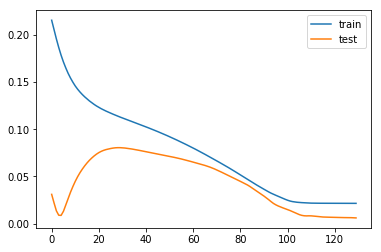

In [52]:
history = model.fit(train_X, train_y, epochs=130, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


Steps taken for prediction:

    Prediction
    Invert scaling for forecast
    Invert scaling for actual
    Calculate RMSE
    Prediction on train
    Invert scaling for train forecast
    Invert scaling for train actual
    Calculate train RMSE
    Calculate MAPE


In [61]:
# make a prediction with model
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

In [63]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [64]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [74]:
# calculate RMSE

testrmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE (Root Mean Squared Error): %.3f' % testrmse)
print('')

testmae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE (Mean Absolute Error): %.3f' % testmae)



def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(inv_y, inv_yhat )
print("Mean Absolute Percentage Error = ", MAPE)

Test RMSE (Root Mean Squared Error): 84.043

Test MAE (Mean Absolute Error): 68.872
Mean Absolute Percentage Error =  1.0672873817384243


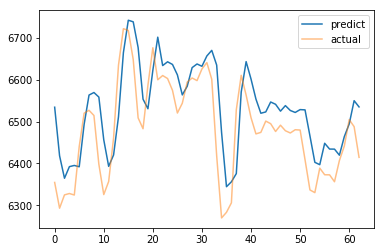

In [75]:
#predicted vs real values
pyplot.plot(inv_yhat, label='predict')
pyplot.plot(inv_y, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

Creating dataframe with predicted, true and percentge difference between predicted and true

In [76]:
d = {'real':inv_y, 'pred':inv_yhat}
pred = DataFrame(data=d)
pred['percentage change'] = (((pred['pred'] - pred['real'])/(pred['real']))*100)
pred['pred_change'] = pred.pred.diff().fillna(0)
pred['real_change'] = pred.real.diff().fillna(0)
print(pred)


           real         pred  percentage change  pred_change  real_change
0   6354.479980  6534.385742           2.831164     0.000000     0.000000
1   6292.930176  6418.219238           1.990950  -116.166504   -61.549805
2   6324.752930  6364.553711           0.629286   -53.665527    31.822754
3   6328.052734  6392.278320           1.014934    27.724609     3.299805
4   6324.442383  6395.156250           1.118104     2.877930    -3.610352
..          ...          ...                ...          ...          ...
58  6406.872559  6419.721680           0.200552   -14.447266    50.671875
59  6441.524902  6464.037109           0.349486    44.315430    34.652344
60  6504.777344  6494.410156          -0.159378    30.373047    63.252441
61  6487.859375  6549.992676           0.957686    55.582520   -16.917969
62  6414.512695  6535.108398           1.880045   -14.884277   -73.346680

[63 rows x 5 columns]


In [77]:
def accuracy(df):
    count = 0
    for index, row in pred.iterrows():
        if row['pred_change'] < 0 and row['real_change'] < 0 or row['pred_change'] > 0 and row['real_change'] > 0:
            count += 1
    return count/len(df)*100

print('Accuracy of correct direction prediction (up/down): ', accuracy(pred))

Accuracy of correct direction prediction (up/down):  57.14285714285714


In [78]:
def variance(df):
    count = 0
    percentage = 0
    for index, row in pred.iterrows():
        if row['pred_change'] < 0 and row['real_change'] > 0 or row['pred_change'] > 0 and row['real_change'] < 0:
            count += 1
            percentage += abs(row['percentage change'])
    return percentage/count

print('Variance of incorrect prediction how far off (up/down): ', variance(pred))

Variance of incorrect prediction how far off (up/down):  0.7190184716421825


In [79]:
def f1_score(df):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for index, row in pred.iterrows():
            if row['pred_change'] < 0 and row['real_change'] < 0: 
                TN += 1
            elif row['pred_change'] > 0 and row['real_change'] > 0:
                TP += 1
            elif row['pred_change'] < 0 and row['real_change'] > 0:
                FN += 1
            elif row['pred_change'] > 0 and row['real_change'] < 0:
                FP += 1

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*((recall*precision)/(recall + precision))
    return f1*100

print('The F1 score:',f1_score(df))

The F1 score: 55.172413793103445
